In [105]:
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import praw
import os
import glob
import time
from tqdm import tqdm
from dotenv import load_dotenv
import datetime as dt
import numpy as np
import pandas as pd
from pymongo import MongoClient
%config Completer.use_jedi = False

os.chdir('/shared/jackie/resilient-communities')

load_dotenv()

reddit = praw.Reddit(
    client_id=os.environ.get('REDDIT_CLIENT_ID_2'),
    client_secret=os.environ.get('REDDIT_CLIENT_SECRET_2'),
    user_agent=os.environ.get('REDDIT_USER_AGENT_2'),
    username=os.environ.get('REDDIT_USERNAME_2'),
    password=os.environ.get('REDDIT_PASSWORD_2')
)

client = MongoClient('localhost', 27017)
all_comments = client.resilient.all
popular_snapshots = client.resilient.popular
ps_comments = client.pushshift_comments
ps_threads = client.pushshift_comments

# Get the total number of comments.

In [106]:
pd.DataFrame.from_dict({
    'Comments': all_comments.estimated_document_count(),
}, orient='index').rename(columns={0: 'N'}).style.format('{:,}')

,N
Comments,"386,500,000"


# Get r/popular thread features.

In [107]:
def get_popular_threads(subreddits=None):

    pipeline = [
        {'$sort': {'retrieved_utc': 1}},  # So snapshots pushed are in order.
        {'$group': {
            '_id': '$id',
            'subreddit': {'$first': '$subreddit'},
            'created_utc': {'$first': '$created_utc'},
            'title': {'$first': '$title'},
            'domain': {'$first': '$domain'},
            'is_self': {'$first': '$is_self'},
            'author': {'$first': '$author'},
            'selftext': {'$first': '$selftext'},
            'is_video': {'$first': '$is_video'},
            'num_snapshots': {'$sum': 1},
            'max_utc': {'$max': '$retrieved_utc'},
            'min_utc': {'$min': '$retrieved_utc'},
            'max_rank': {'$max': '$rank'},
            'min_rank': {'$min': '$rank'},
            'mean_rank': {'$avg': '$rank'},
            'max_upvotes': {'$max': '$score'},
            'min_upvotes': {'$min': '$score'},
            'mean_upvotes': {'$avg': '$score'},
            'max_upvote_ratio': {'$max': '$upvote_ratio'},
            'min_upvote_ratio': {'$min': '$upvote_ratio'},
            'mean_upvote_ratio': {'$avg': '$upvote_ratio'},
            'snapshots': {'$push': {
                'retrieved_utc': '$retrieved_utc',
                'rank': '$rank',
                'score': '$score',
                'upvote_ratio': '$upvote_ratio',
                'num_comments': '$num_comments'
            }}
        }}
    ]

    if subreddits is not None:
        pipeline = [{'$match': {'subreddit': {'$in': subreddits}}}] + pipeline

    popular_threads = pd.DataFrame(
        popular_snapshots.aggregate(pipeline, allowDiskUse=True)
    ).rename(columns={'_id': 'id'}).set_index('id')

    for column in ['created_utc', 'max_utc', 'min_utc']:
        new_column = column.split('_')[0] + '_datetime'

        popular_threads[new_column] = \
            pd.to_datetime(popular_threads[column], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central')

    popular_threads['created_to_popular'] = popular_threads['min_utc'] - \
        popular_threads['created_utc']

    popular_threads['popular_window'] = popular_threads['max_utc'] - \
        popular_threads['min_utc']

    return popular_threads


popular_threads = get_popular_threads()
popular_threads

,subreddit,created_utc,title,domain,is_self,author,selftext,is_video,num_snapshots,max_utc,...,mean_upvotes,max_upvote_ratio,min_upvote_ratio,mean_upvote_ratio,snapshots,created_datetime,max_datetime,min_datetime,created_to_popular,popular_window
id,,,,,,,,,,,,,,,,,,,,,
qqyi5z,copypasta,1.651465e+09,Predictions Tournament,reddit.com,False,Ragnar_OK,,False,184,1652557866,...,67126.402174,0.92,0.92,0.920000,"[{'retrieved_utc': 1651509021, 'rank': 45, 'sc...",2022-05-01 23:23:14-05:00,2022-05-14 14:51:06-05:00,2022-05-02 11:30:21-05:00,43627.0,1048845
qued9b,IndianDankMemes,1.648148e+09,Predictions Tournament,reddit.com,False,PharoahtheGod,,False,253,1652726435,...,22727.169960,0.99,0.95,0.968182,"[{'retrieved_utc': 1648191742, 'rank': 67, 'sc...",2022-03-24 13:45:38-05:00,2022-05-16 13:40:35-05:00,2022-03-25 02:02:22-05:00,44204.0,4534693
rw8i7w,HolUp,1.648715e+09,HOL'UPREDICTIONS: SEASON TWO,reddit.com,False,AsherFennec,,False,222,1649434363,...,109952.184685,0.93,0.92,0.921982,"[{'retrieved_utc': 1648759320, 'rank': 6, 'sco...",2022-03-31 03:26:37-05:00,2022-04-08 11:12:43-05:00,2022-03-31 15:42:00-05:00,44123.0,675043
sbr44n,worldnewsvideo,1.648211e+09,r/Worldnewsvideo's User Prediction Contest for...,reddit.com,False,PlenitudeOpulence,,False,1021,1651615980,...,36235.650343,0.94,0.92,0.926376,"[{'retrieved_utc': 1648254922, 'rank': 33, 'sc...",2022-03-25 07:16:57-05:00,2022-05-03 17:13:00-05:00,2022-03-25 19:35:22-05:00,44305.0,3361058
t4btt4,wallstreetbets,1.648394e+09,🔮WallStreetBets Predictions Tournament for Mar...,reddit.com,False,ThetaGang_wsb,,False,57,1648444695,...,55849.894737,0.97,0.97,0.970000,"[{'retrieved_utc': 1648437841, 'rank': 39, 'sc...",2022-03-27 10:15:35-05:00,2022-03-28 00:18:15-05:00,2022-03-27 22:24:01-05:00,43706.0,6854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
usl126,MurderedByWords,1.652903e+09,That's just crazy talk,i.redd.it,False,beerbellybegone,,False,77,1652916461,...,13808.883117,0.92,0.83,0.883247,"[{'retrieved_utc': 1652907087, 'rank': 65, 'sc...",2022-05-18 14:43:21-05:00,2022-05-18 18:27:41-05:00,2022-05-18 15:51:27-05:00,4086.0,9374
uslhnw,MadeMeSmile,1.652904e+09,"(OC) I’m 17, and this is the first time I’ve b...",i.redd.it,False,Available_Donut_8450,,False,43,1652916461,...,7276.976744,0.86,0.80,0.827907,"[{'retrieved_utc': 1652911269, 'rank': 89, 'sc...",2022-05-18 15:05:06-05:00,2022-05-18 18:27:41-05:00,2022-05-18 17:01:09-05:00,6963.0,5192
uslknb,antiwork,1.652905e+09,We need to thrive not just survive,i.redd.it,False,LexiStarrDust,,False,18,1652916461,...,5957.277778,0.99,0.98,0.985556,"[{'retrieved_utc': 1652914373, 'rank': 99, 'sc...",2022-05-18 15:09:04-05:00,2022-05-18 18:27:41-05:00,2022-05-18 17:52:53-05:00,9829.0,2088


# Get the comments from each r/popular thread.

In [121]:
def get_popular_comments():

    assert popular_threads is not None, 'Get r/popular threads.'

    fullnames = 't3_' + popular_threads.index

    popular_comments = pd.DataFrame(
        all_comments.aggregate([
            {'$match': {'link_id': {'$in': fullnames.tolist()}}}
        ], allowDiskUse=True)
    ).set_index('id')

    return popular_comments

popular_comments = get_popular_comments()
popular_comments

AutoReconnect: connection closed

# Visualizations

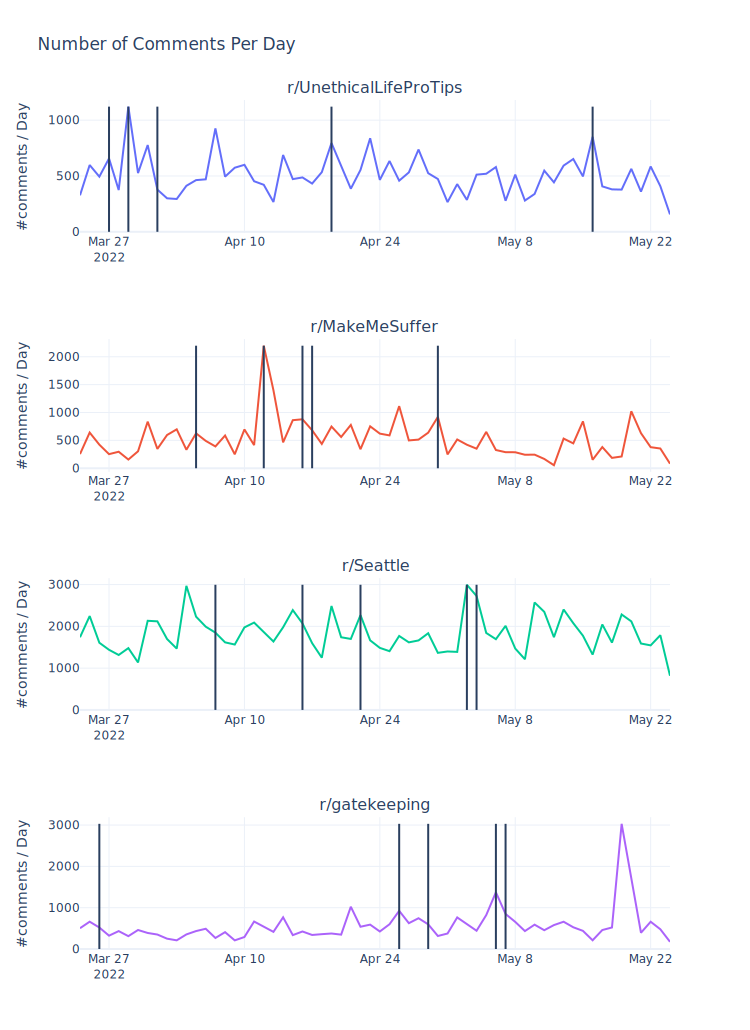

In [223]:
def get_subreddit_comments(subreddits):

    return pd.DataFrame(
        all_comments.aggregate([
            {'$match': {'subreddit': {'$in': subreddits}}},
            {'$project': {'subreddit': 1, 'created_utc': 1}}
        ])
    )


def get_popular_timestamps(subreddits):

    assert popular_threads is not None, 'Get r/popular threads.'

    mask = popular_threads['subreddit'].isin(subreddits)

    timestamps = popular_threads[mask][['subreddit', 'min_datetime']]

    return timestamps


def count_comments(comments, bin_size):
    count = pd.to_datetime(comments['created_utc'], unit='s') \
        .dt.tz_localize('UTC') \
        .dt.tz_convert('US/Central') \
        .round(bin_size) \
        .value_counts() \
        .sort_index()

    count = count.reindex(
        pd.date_range(count.index[0], count.index[-1], freq=bin_size)
    )

    return count


def display_subreddit_comments(subreddits, save=False, bin_size='H'):

    assert bin_size == 'H' or bin_size == 'D', 'bin_size should either be \'H\' or \'D\'.'

    comments = get_subreddit_comments(subreddits)

    popular_timestamps = get_popular_timestamps(subreddits)

    fig = make_subplots(
        rows=len(subreddits),
        subplot_titles=tuple([f'r/{subreddit}' for subreddit in subreddits])
    )

    for i, subreddit in enumerate(subreddits):
        subreddit_comments = comments[comments['subreddit'] == subreddit]

        mask = popular_timestamps['subreddit'] == subreddit
        subreddit_popular_timestamps = popular_timestamps[mask]['min_datetime'].round('D').unique()

        count = count_comments(subreddit_comments, bin_size)

        fig.add_trace(
            go.Scatter(
                x=count.index,
                y=count.values
            ), row=i+1, col=1
        )
        
        for timestamp in subreddit_popular_timestamps:
            fig.add_shape(
                type='line',
                x0=timestamp, x1=timestamp,
                y0=0, y1=count.max(),
                row=i+1, col=1
            )

    bin_size_string = 'Hour' if bin_size == 'H' else 'Day'

    fig.update_layout(
        template='plotly_white',
        showlegend=False,
        height=30+250*len(subreddits),
        width=750,
        title='Number of Comments Per ' + bin_size_string
    )

    for i in range(1, len(subreddits) + 1):
        fig.layout[f'yaxis{i}'].title = '#comments / ' + bin_size_string

    if save:
        fig.write_image('figs/subreddit_timeline.png', scale=3)

    fig.show('svg')


display_subreddit_comments(
    ['UnethicalLifeProTips', 'MakeMeSuffer', 'Seattle', 'gatekeeping'],
    save=True,
    bin_size='D'
)

In [ ]:
def display_popular_threads(save=False):
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    sufficiently_old = popular_threads['max_datetime'] \
        < (dt.datetime.now() - dt.timedelta(days=5))
    
    sampled_threads = popular_threads[sufficiently_old].sample(n=3)
    
    sampled_snapshots = [pd.DataFrame(snapshots) for snapshots in sampled_threads['snapshots']]
    
    titles = [
        f'<a href="https://reddit.com/{thread.id}" target="_blank">r/{thread.subreddit} Thread Link</a>'
        for thread in sampled_threads.itertuples()
    ]
    
    fig = make_subplots(
        rows=4, cols=3,
        subplot_titles=(titles[0], titles[1], titles[3],
                       '', '', '',
                       '', '', '',
                       '', '', '')
    )
    
    for col, snapshots in enumerate(sampled_snapshots):
        
        snapshots['datetime'] = pd.to_datetime(snapshots['retrieved_utc'], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central')
        
        for row, column in enumerate(['rank', 'score', 'upvote_ratio', 'num_comments']):
            fig.add_trace(
                go.Scatter(x=snapshots['datetime'], y=snapshots[column]),
                row=row+1, col=col+1
            )
            
            fig.update_yaxes(title=column.replace('_', ' ').title(),
                            row=1, col=col+1)
            
        fig.update_layout(
            template='plotly_white',
            height=900,
            width=1200,
            showlegend=False,
            title=f'Sampled r/popular Thread Properties'
        )
        
        if save:
            fig.write_image('figs/sampled_popular.png', scale=3)
            
        fig.show('svg')
    
display_popular_threads()

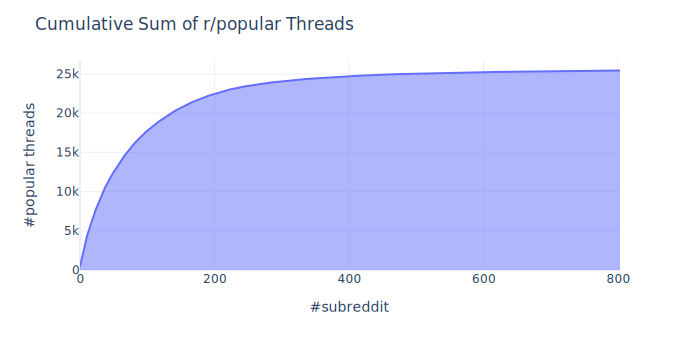

In [140]:
def display_cumulative_sum(save=False):
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    data = popular_threads['subreddit'] \
        .value_counts() \
        .cumsum() \
        .reset_index()['subreddit']
    
    fig = px.area(data)
    
    fig.update_layout(
        template='plotly_white',
        showlegend=False,
        xaxis_title='#subreddit',
        yaxis_title='#popular threads',
        title='Cumulative Sum of r/popular Threads',
        height=350,
    )
    
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)
    
    fig.show('svg')
    
    if save:
        fig.write_image('figs/cumulative_sum.png', scale=3)
        
display_cumulative_sum(save=True)

In [372]:
def describe_popular_threads(to_latex=False):
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    table = pd.DataFrame()
    
    table = table.append((popular_threads['created_to_popular'] / 3600).describe())
    table = table.append((popular_threads['popular_window'] / 3600).describe())
    
    table.index = ['Created to Popular (hours)', 'Popular Window (hours)']
    
    table = table.rename(columns={
        'max': 'Max',
        'mean': 'Mean',
        'count': 'N',
        'min': 'Min',
        'std': 'SD'
    })
    
    table = table.round(2)
    
    columns = ['25%', '50%', '75%', 'Min', 'Mean', 'Max', 'SD', 'N']
    
    for column in columns:
        table[column] = table[column].apply(lambda x: f'{x:,}')
    
    table = table[columns].transpose()
    
    if to_latex:
        
        columns = table.columns
        
        table = table.to_latex(bold_rows=True, column_format='rrr')
        
        for rule in ['\\toprule', '\\midrule', '\\bottomrule']:
            table = table.replace(rule, '\hline')
            
        for column in columns:
            table = table.replace(column, f'\\textbf{{{column}}}')
            
        table = table[:table.rfind('\\textbf{N') - 1] + ' \hline' + table[table.rfind('\\textbf{N') - 1:]
        
        print(table)
    else:
        return table

describe_popular_threads(to_latex=True)

\begin{tabular}{rrr}
\hline
{} & \textbf{Created to Popular (hours)} & \textbf{Popular Window (hours)} \\
\hline
\textbf{25\% } &                       3.01 &                   1.73 \\
\textbf{50\% } &                       4.28 &                   4.62 \\
\textbf{75\% } &                       6.39 &                   8.98 \\
\textbf{Min } &                       0.17 &                    0.0 \\
\textbf{Mean} &                       5.36 &                   6.04 \\
\textbf{Max } &                      24.22 &               1,259.64 \\
\textbf{SD  } &                       3.52 &                  14.93 \\ \hline
\textbf{N   } &                   25,440.0 &               25,440.0 \\
\hline
\end{tabular}



In [274]:
(popular_threads['popular_window'] / 3600).describe()

count    25440.000000
mean         6.043008
std         14.928078
min          0.000000
25%          1.732500
50%          4.619583
75%          8.980694
max       1259.636944
Name: popular_window, dtype: float64

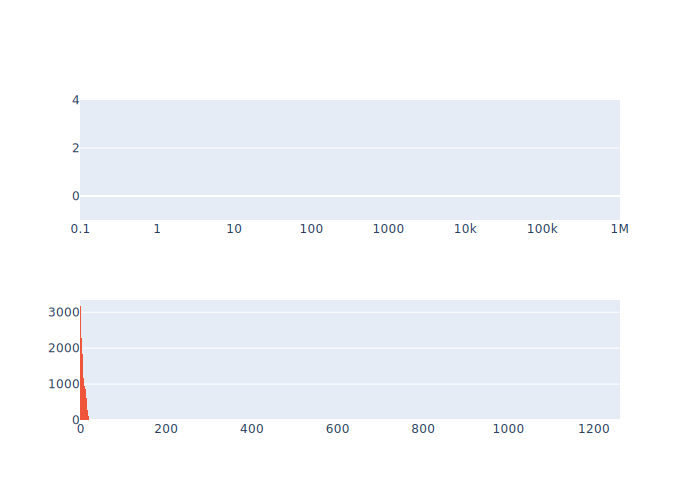

In [273]:
def display_popular_distributions(save=False):
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    created_to_popular_data = popular_threads['created_to_popular'] / 3600
    popular_window_data = popular_threads['popular_window'] / 3600
    
    fig = make_subplots(
        rows=2,
        subplot_titles=('', '')
    )
    
    fig.add_trace(
        go.Histogram(x=created_to_popular_data),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Histogram(x=popular_window_data),
        row=2, col=1
    )
    
    fig.update_layout(showlegend=False, xaxis_type='log')
    fig.update_traces(histnorm='probability')
    
#     fig.update_xaxes(type='log')
    
    
    fig.show('svg')
    
display_popular_distributions()

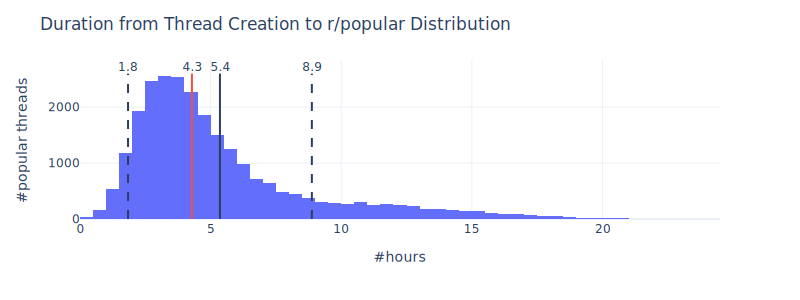

In [224]:
def display_created_to_popular_distribution(save=False):
    
    assert popular_threads is not None, 'Get r/popular threads.'

    data = popular_threads['created_to_popular'] / 3600

    fig = px.histogram(data, nbins=50)

    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)

    fig.add_shape(
        type='line',
        x0=data.median(), x1=data.median(),
        y0=0, y1=2600,
        line=dict(color=px.colors.qualitative.Plotly[1])
    )
    
    fig.add_shape(
        type='line',
        x0=data.mean(), x1=data.mean(),
        y0=0, y1=2600
    )

    fig.add_shape(
        type='line',
        x0=data.mean() - data.std(), x1=data.mean() - data.std(),
        y0=0, y1=2600,
        line=dict(dash='dash')
    )

    fig.add_shape(
        type='line',
        x0=data.mean() + data.std(), x1=data.mean() + data.std(),
        y0=0, y1=2600,
        line=dict(dash='dash')
    )

    fig.add_trace(go.Scatter(
        x=[data.mean(),
           data.mean() - data.std(),
           data.mean() + data.std(),
           data.median()],
        y=[2700, 2700, 2700, 2700],
        text=[f'{data.mean():.1f}',
              f'{data.mean() - data.std():.1f}',
              f'{data.mean() + data.std():.1f}',
              f'{data.median():.1f}'],
        mode='text'
    ))
    
    fig.update_layout(
        template='plotly_white',
        showlegend=False,
        xaxis_title='#hours',
        yaxis_title='#popular threads',
        title='Duration from Thread Creation to r/popular Distribution',
        bargap=0,
        height=300,
        width=800
    )

    fig.show('svg')

    if save:
        fig.write_image('figs/created_to_popular_distribution.png', scale=3)


display_created_to_popular_distribution(save=True)